# Lidl case study

**Table of Contents**:
1. Summary
2. Goals, assumptions and testing setup
3. Data overview
3. Explanatory data analysis
4. Correlation analysis
4. Regression model
5. Regression trees

# 1. Summary
The goal of this analysis was to identify important features of existing products, to derive new store brand offering products. Data was collected from the US Halloween survey. We applied both regression and tree-based approaches. 
Together with descriptive analysis, the new store brand offering should be defined as:

* **Must have**: Chocolate flavor. 
* **Preferred** : Peanuts / almonds addition.
* **Worth considering**: Crisped rice wafer, higher sugar content (compared to sweet market average).
* **Not preferred**: Fruit flavor.

# 2. Goals, assumptions and testing setup

***Goal***: 
Identify important features of existing products, to define general characteristics of a new product (store brand offering). This will serve as a basis for future brand product offerings. The features are selected purely in relation to consumer preference, based on the **win percentage**.

***Setup***: 
Dataset is collected from an online survey of 269,000 matchups from 8,371 unique IP addresses. This means, on average, each participant voted approx. 32 times. The matchup can be explained as a choice of each pair by comparison. Win of matchup is encoded as 1 and loss as 0. The final target variable represents the ratio of *# Wins* to *# wins* candy has been in. f.e. from our dataset, the highest voted candy is **Reese's Peanut Butter cup** with the win percent of approx. 84%, meaning, 84 times out of every 100 matchups the voter would choose candy over any other one.an onlinedataset,

***Assumptions***:
* The matchup was defined as the personal preference of one of two candies for Halloween. This does not fully align with the consumer shopping behaviour, not considering price sensitivity to the candy being gifted rather than bought. This assumption might: 
 	* create price insensivity of consumers.
	* not reflect customer behaviour if prices are considered.
* The survey is defined based on American household preferences. This might not reflect the preferences of other markets. 
* There is no explicit mention of the sampling of the matchups. Modeller assumes, that based on the # of matchups, each candy was being represented sufficiently.
* The only metric considered for analysis is *winpct*. There might be other considerations from the business side related not purely obtaining most sales, but rather for candy to be part of some strategy with the favourable *winpct* rate. One of the examples might be that a business would like to expand their health line, looking for a sweet to complement this line. In this case, the modeler would apply a different approach.

***Testing setup***: Due to constraint of # provided parameters and goal of the analysis, compared to traditional analysis, we decided not to split data into training and testing sample. The goal is to identify important features rather than define optimal prediction model. The model will consider prediction metrics as indicators of the quality of feature definition.

[Data source](https://github.com/fivethirtyeight/data/tree/master/candy-power-ranking) 

# 3. Data overview

The dataset consists of 11 explanatory variables and 1 target variable (*win_pct*). Some of the variables were renamed to reflect their definition. Variables with the suffix *_flg* are defined as: 1 if property present else 0. Variables with suffix *_pct* are normalized percent proportion, to mean and standard deviation of all measured values. The following properties are collected:
* **Flavor**: Chocolate, Fruity
* **Additives**: Caramel, Peanuts/Almonds, Nougat, Crisped rice wafer
* **Consistency**: Hard, Bar, Multiple pieces
* **Sugar**: Sugar ratio (0-100%)
* **Price**: Price ratio (0-100%)

The variable we are trying to explain is: **win_pct**. 
There are 85 distinct chocolates to be considered.

In [10]:
%%capture

# Run if any of the packages are missing, otherwise skip
! pip install pandas pandas seaborn scipy sklearn statsmodels shap

In [11]:

from calc import * 

pd.set_option('display.float_format', lambda x: '%.4f' % x)


url = "https://raw.githubusercontent.com/fivethirtyeight/data/master/candy-power-ranking/candy-data.csv"
df = load_dataset(url)
y = 'win_pct'

EDA = univariate_analysis(df, y)

print(f"# of rows: {df.shape[0]}")
print(f"# of columns: {df.shape[1]}")
print(f"# of missing values: {df.isna().sum().sum()}")
print(f'Dataset columns: {df.columns.to_list()}')

# of rows: 85
# of columns: 12
# of missing values: 0
Dataset columns: ['chocolate_flg', 'fruity_flg', 'caramel_flg', 'peanutyalmondy_flg', 'nougat_flg', 'crispedricewafer_flg', 'hard_flg', 'bar_flg', 'pluribus_flg', 'sugar_pct', 'price_pct', 'win_pct']


# 4. Explanatory data analysis

## 4.1 Binary Features 

 There are no missing values. The presence of some additives such as nougat and crispedwafer is relatively low and might result in insignificance of parameter. The proportion of chocolate and fruit candies are relatively comparable. There is approx 50% of multipiece candies. Most of the selected candies were non-hard candies or non-bar form. 

In [12]:
EDA['binary_properties']

,count,mean,std
properties,,,
chocolate_flg,85.0000,0.4353,0.4987
fruity_flg,85.0000,0.4471,0.5001
caramel_flg,85.0000,0.1647,0.3731
peanutyalmondy_flg,85.0000,0.1647,0.3731
nougat_flg,85.0000,0.0824,0.2765
crispedricewafer_flg,85.0000,0.0824,0.2765
hard_flg,85.0000,0.1765,0.3835
bar_flg,85.0000,0.2471,0.4339
pluribus_flg,85.0000,0.5176,0.5027


Visualization of the *win_pct* with respect to the category was visualized. The presence of chocolate , peanuts / almonds and bar shape resulted in higher score. In contrast, the fruity and hard candies seem to be unpopular. Some of the factors not seem to influence score.

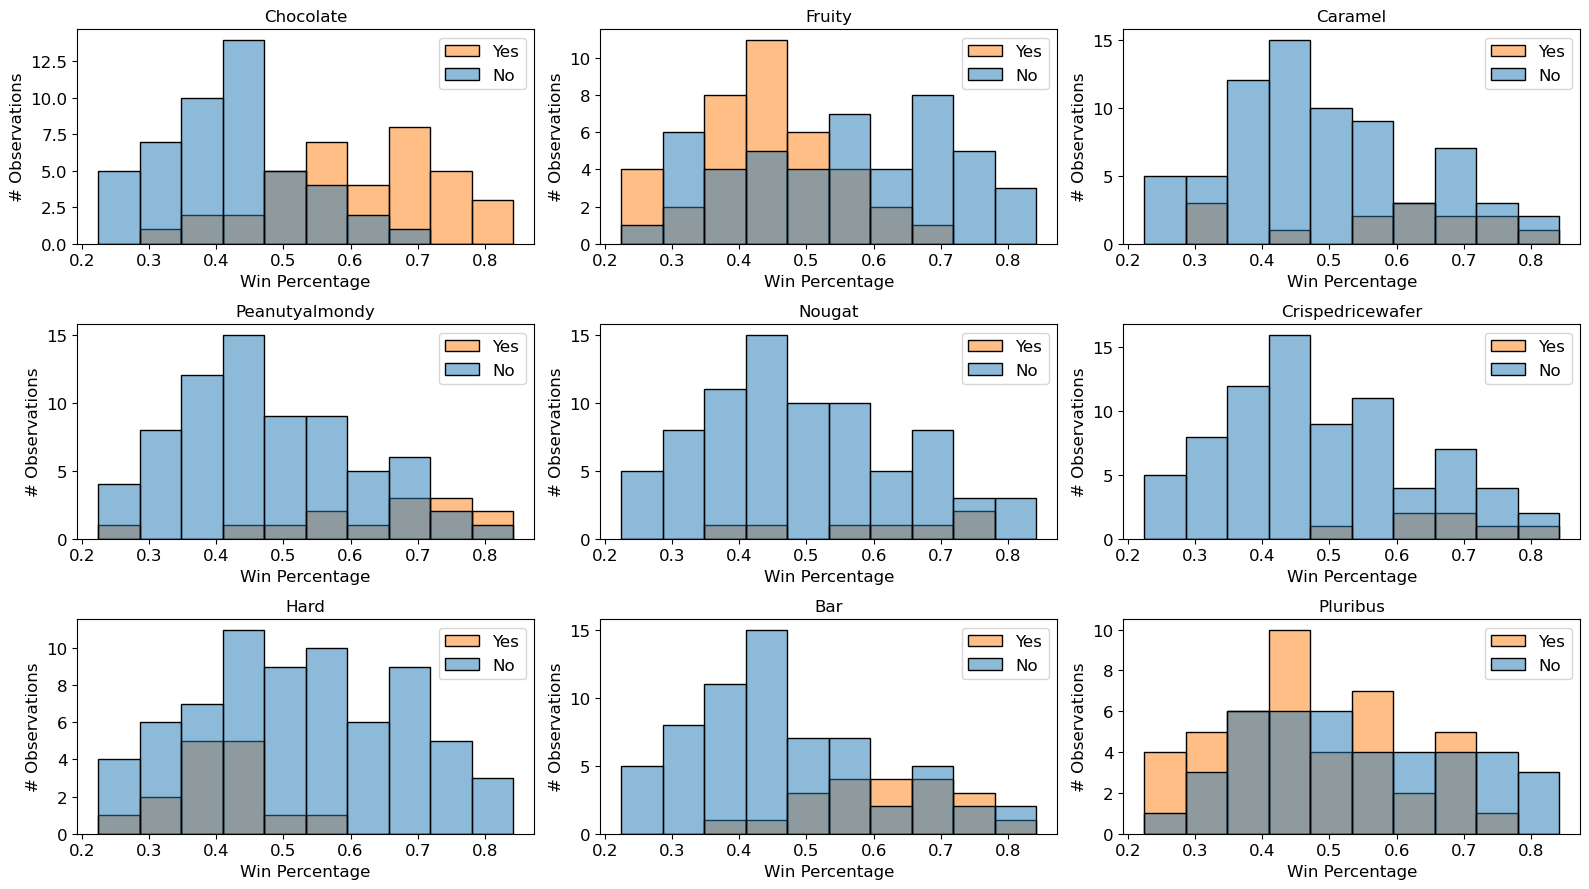

In [13]:
visualize_cat_vars(df, y)

## Numeric features
There are no missing values. 
The candy with the least amount of sugar *One dime*, a single piece candy without any added ingredients, did poorly, being in worst 10 candies, despite being relatively cheap. As expected, due to normalization, both sugar and price metrics mean 50%. 
On the other hand, the sweetest candy *Reese's stuffed with pieces* did contain some of the ingredients (chocolate, peanuts / almonds), resulting in a high percentage, with the price being above average.

In [14]:
EDA['numeric_properties']

,count,mean,std,min,max
properties,,,,,
sugar_pct,85.0000,0.4786,0.2828,0.0110,0.9880
price_pct,85.0000,0.4689,0.2857,0.0110,0.9760
win_pct,85.0000,0.5032,0.1471,0.2245,0.8418


Both the increase in sugar percentage as well increase of price resulted in a higher percentage. So, positive relationship between explanatory and target variable is present. 

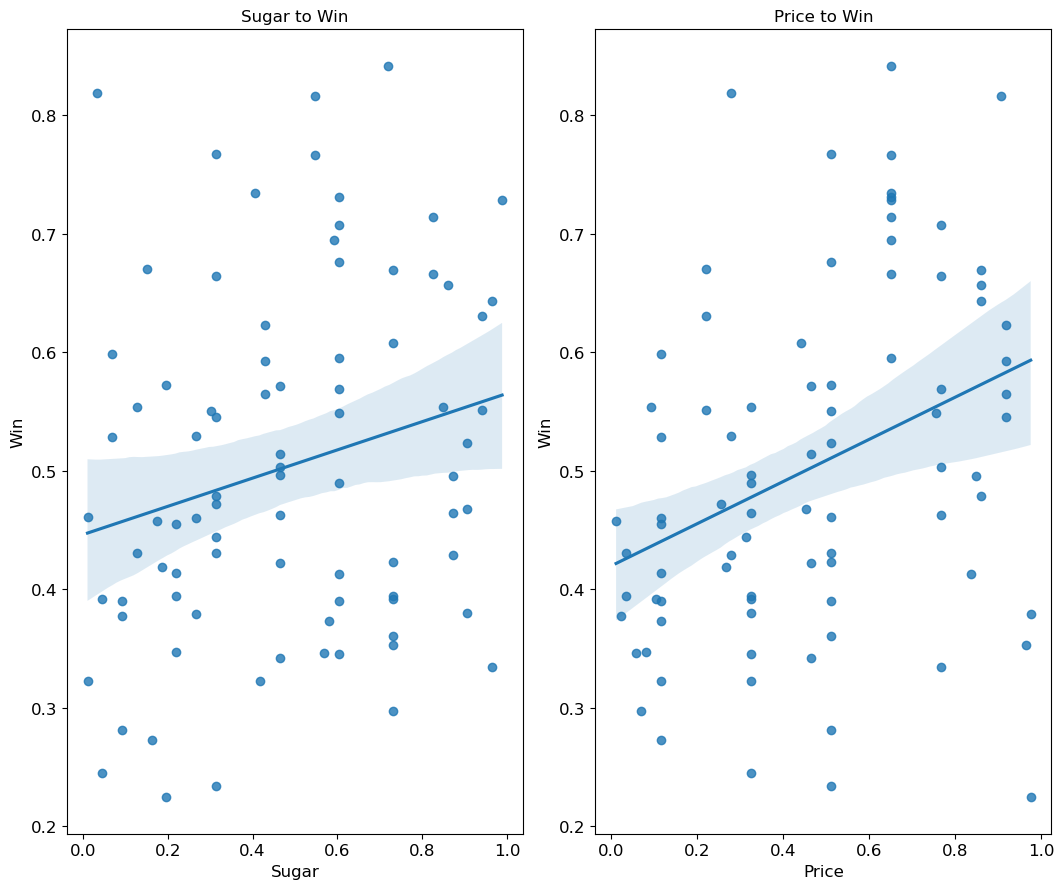

In [15]:
visualize_num_vars(df, y)

## Worst vs best candies

Comparison of top 10 to worst 10 candies was done. Significant differences were observed:
* All candies from the top 10 group contain chocolate, compared to none from worst.
* 4 out of 10 worst candies were fruity. 
* The combination of chocolate and fruity is rare combination. Only 1 candy *Tootsie Pop* contains both.
* Peanuts/Almonds are good additive. 7 out of 10 candies from top 10 did contains peanut almods.
* Proportion of sugar in the top 10 is higher to worst candies by +22 p.p.
* Win percentage between top 10 worst and top 10 best is approx. 48 p.p.

In [16]:
EDA['top10_vs_bottom10']

group,best,worst,diff
properties,,,
chocolate_flg,1.0000,0.0000,1.0000
fruity_flg,0.0000,0.4000,-0.4000
caramel_flg,0.3000,0.2000,0.1000
peanutyalmondy_flg,0.7000,0.1000,0.6000
nougat_flg,0.2000,0.0000,0.2000
crispedricewafer_flg,0.2000,0.0000,0.2000
hard_flg,0.0000,0.2000,-0.2000
bar_flg,0.5000,0.0000,0.5000
pluribus_flg,0.2000,0.7000,-0.5000


# Correlation analysis

Correlation of explanatory variables was done to identify multicollinearity within the dataset, affecting final model performance. The strategy chosen for this analysis was to remove variables with lower prediction power, if the multicollinearity is present above defined thresholds (0.70). The high negative correlation is present for chocolate and fruit pair, approx. -74%. This is in line with the analysis above. The *fruit_flg* affects the final prediction by lowering the score. Another noticeable fact is that chocolate sweets are bars (20-21 bars) as well as all nugat sweets. Also, chocolate bars are more expensive than non-chocolate bars by +29 p.p. This assumption was also tested by 2 sample t-test, rejecting the null hypothesis of equality of mean values on level alpha < 0.01 chocolates.

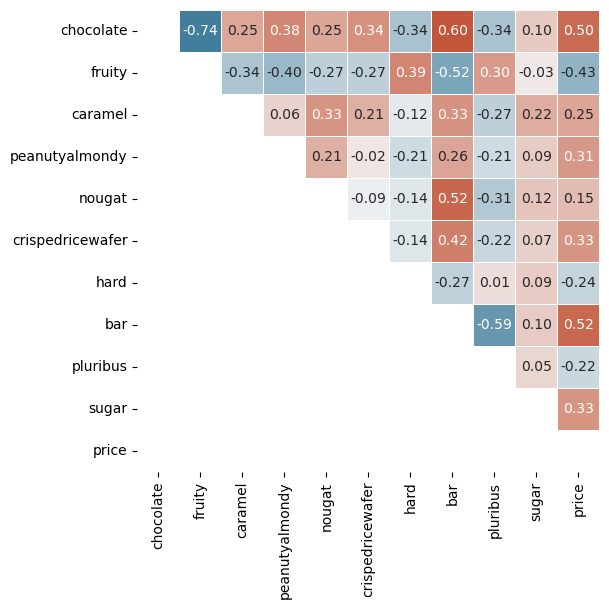

In [17]:
correlation_matrix(df, y)

## Setup for modelling
Before applying different modelling techniques, some of the adjustments to the model will be made: 
* Price percentage *price_pct* will be excluded from modelling, due to price is not considered in survey
* Fruit flavor *fruit_flg* will be excluded from modelling, due to high correlation with the chocolate flavor. This was chosen based on the EDA.
* New feature of high sugar presence *high_sugar_flg* was defined. This is defined as products with 50%+ (incl.) of the normalized sugar percentage. There is a noticable increase of *win_pct* of approx. 7 p.p between high-sugar and non-high sugar group. This was tested using t-test with 2 sample t-test (alpha < 0.05).

In [18]:
df['high_sugar_flg'] = df['sugar_pct'].apply(lambda x: 1 if x >= 0.50 else 0)

x_var = df.drop(columns = [y, 'fruity_flg', 'sugar_pct', 'price_pct']).columns.to_list()
y_var = y

# Regression model

OLS was applied on the model. Multiple setups were run on the data. 

The following approach was adopted: 
* Run regression using all available indicators. Due to low number of indicators no forward, stepwsise or backward selection was applied. The results for R2-adjusted is 43.5%. For the next itteration variables with the signigicance level of < 0.10 were considered. The criterion to follow was the R2-adjusted, considering penalty imposed by the model parameters.
* Run regression using final parameter selection considering R2-adjusted, with final selection: 

    * chocolate_flg : Best predictor. Can explain approx. 40% of variance if used separately in reg. Positive correlation with the target increasing baseline by approx. +14.5 pp.

    * peanutyalmondy_flg : Second best predictor, significant at alpha level 0.05, positive effect on score.

    * crispedricewafer_flg: Significant at alpha level 0.10, positive effect on overall score.
    
    * high_sugar_flg: Significant on alpha level 0.10, positive effect on overall score.

The final model estimation was selected due to small deterioration of R2 (0.495 - 0.481) with the increase of R2-adj due to elimination of statistically insignificant variables. Also, the final model is simple and all variables exhibit behavior as observed from EDA analysis. Each effect can be translated as an add-on to baseline score of 40 pp., meaning, candies with chocolate, regardless of other effects, are about 15 pp. more likable to be selected rather than non chocolate candies.


The final model with detailed description can be found below.

In [19]:
x_selected = ['chocolate_flg','peanutyalmondy_flg','crispedricewafer_flg','high_sugar_flg']

In [20]:
# Train model
lm = linear_regression(df[x_selected], df[y_var])

In [21]:
lm['model_fit']

,0,1,2,3
0,Model:,OLS,Adj. R-squared:,0.455
1,Dependent Variable:,win_pct,AIC:,-131.2875
2,Date:,2023-04-28 11:52,BIC:,-119.0743
3,No. Observations:,85,Log-Likelihood:,70.644
4,Df Model:,4,F-statistic:,18.52
5,Df Residuals:,80,Prob (F-statistic):,8.28e-11
6,R-squared:,0.481,Scale:,0.011802


In [22]:
lm['params_est'] 

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,0.3996,0.0186,21.5320,0.0000,0.3627,0.4366
chocolate_flg,0.1452,0.0277,5.2392,0.0000,0.0901,0.2004
peanutyalmondy_flg,0.0819,0.0349,2.3470,0.0214,0.0125,0.1514
crispedricewafer_flg,0.0799,0.0463,1.7255,0.0883,-0.0123,0.1721
high_sugar_flg,0.0441,0.0238,1.8486,0.0682,-0.0034,0.0915


In [23]:
top3 = obtain_names_based_on_rank(df.win_pct, True, 3)
bot3 = obtain_names_based_on_rank(df.win_pct, False, 3)

shap_top3 = shapley_explainer(lm['model_est'], df.loc[:, x_selected], df.loc[top3, x_selected])
shap_bot3 = shapley_explainer(lm['model_est'], df.loc[:, x_selected], df.loc[bot3, x_selected])

## Shapley values of partial dependance plot
Comming from the game theory, shapley values is a useful measurement to contribution of each individual feature to final model prediction. 

The general idea can be explained as follow: 
1. Calculate average prediction for the whole sample using prediction model.
2. Calculate contribution of each individual component to the overall predicted power of a given sweet.
3. Assign final prediction value for given observation.

For top 3 candies, we can see that missing of *crispericewafer_flg* or *high_sugar_flg* only marginally deteriorates score compared to the effect being present in overall sample.

For worst 3 candies, we can see negative effect if all effects are missing. The most deteriorating factor is *chocolate_flg*.

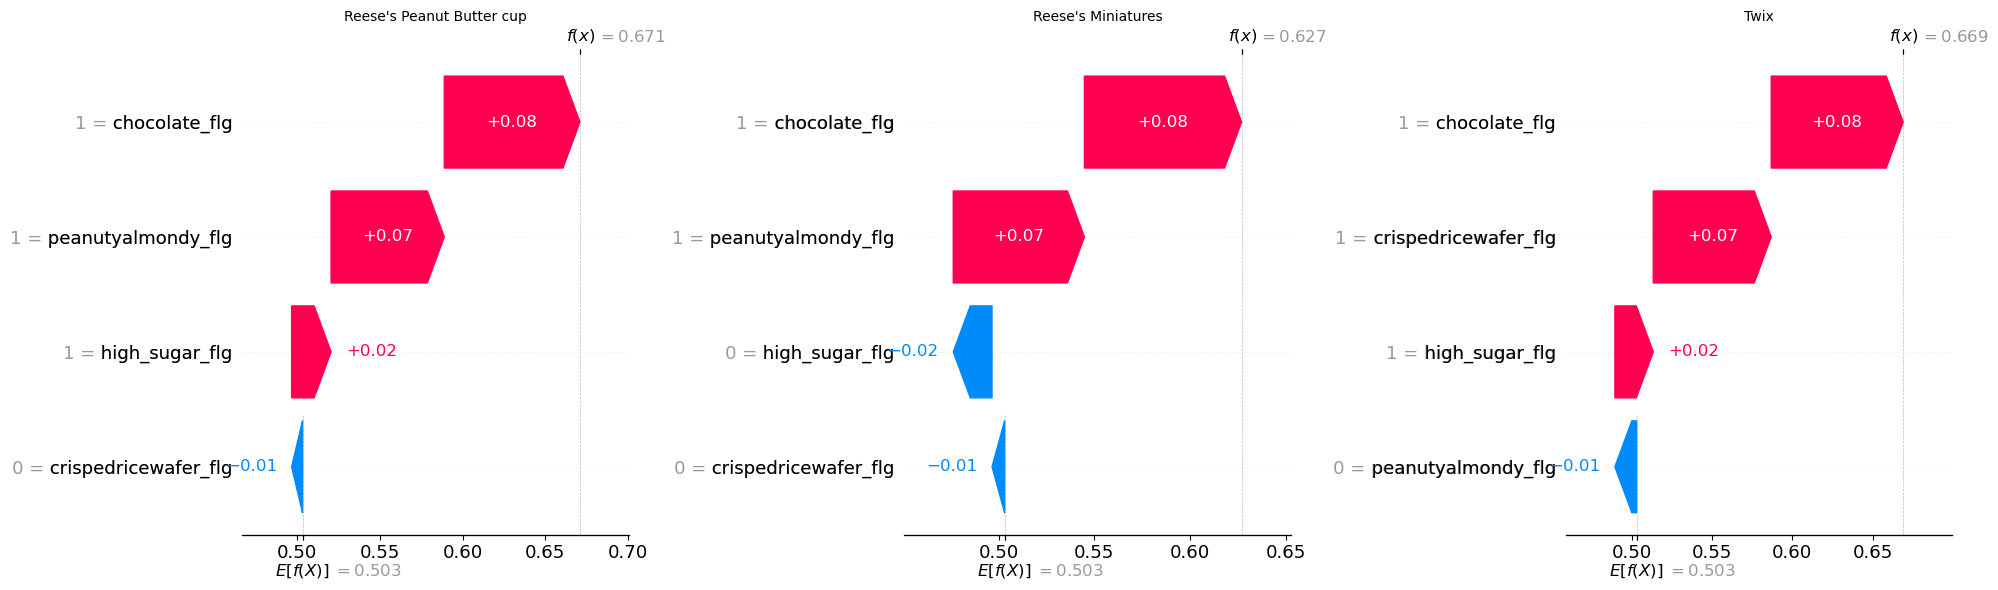

In [24]:
visualize_shapley(shap_top3, top3)

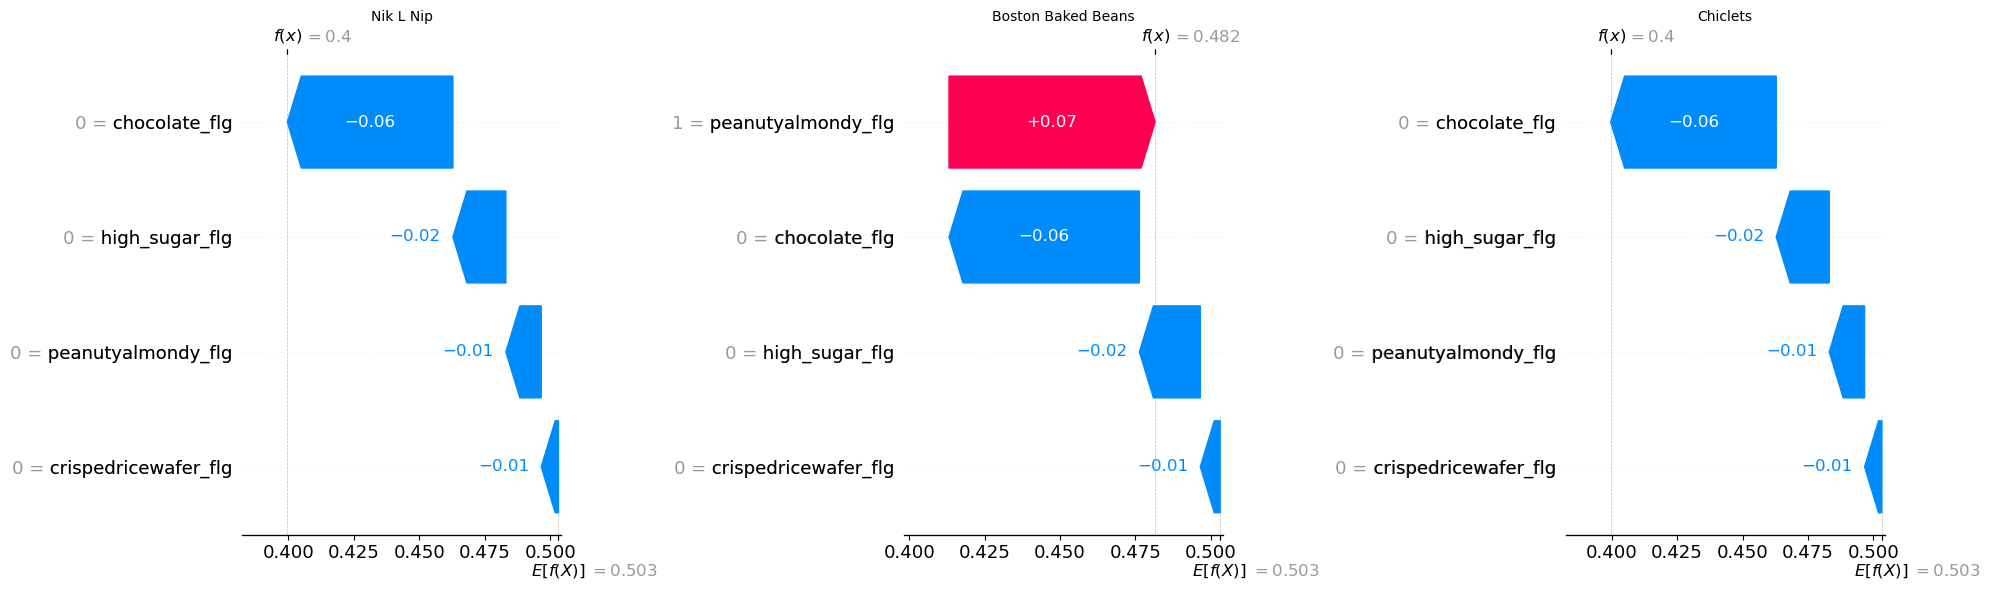

In [25]:
visualize_shapley(shap_bot3, bot3)

# Regression trees

Regression trees were constructed. Hyperparameters were chosen to not overfit the model with the respect to the MAE metric. Final tree depth selected for the construction was 2. Optimum criterion is squared-error, with the minimum proportion is leaf of 10% of overall observations.

Important effects: 

* chocolate_flg : Relative importance of 0.87. Significantly increasing positivity compared to non-chocolate. 
* peanutyalmondy_flg : Second best predictor, with relative importance 0.12. Increase of positivity compared to be non present

The regression tree indicated importance of *chocolate_flg* and *peanutyalmondy_flg*. Other factors are non-important. The factors from linear regression seem not to be selected for split due to definition of the hyperparameters or due to the fact other variables provides better split for optimum search. 

The final model with detailed description, model structure and shapley values are present bellow.

*************** Tree Summary ***************
Tree Depth:  2
No. of leaves:  4
No. of features:  9
Accuracy Score:  0.47
Mean Absolute Error: 0.09
*************** Variable importance ***************
Variable: chocolate_flg        Importance: 0.87
Variable: peanutyalmondy_flg   Importance: 0.12
Variable: hard_flg             Importance: 0.01
Variable: caramel_flg          Importance: 0.0
Variable: nougat_flg           Importance: 0.0
Variable: crispedricewafer_flg Importance: 0.0
Variable: bar_flg              Importance: 0.0
Variable: pluribus_flg         Importance: 0.0
Variable: high_sugar_flg       Importance: 0.0
--------------------------------------------------------



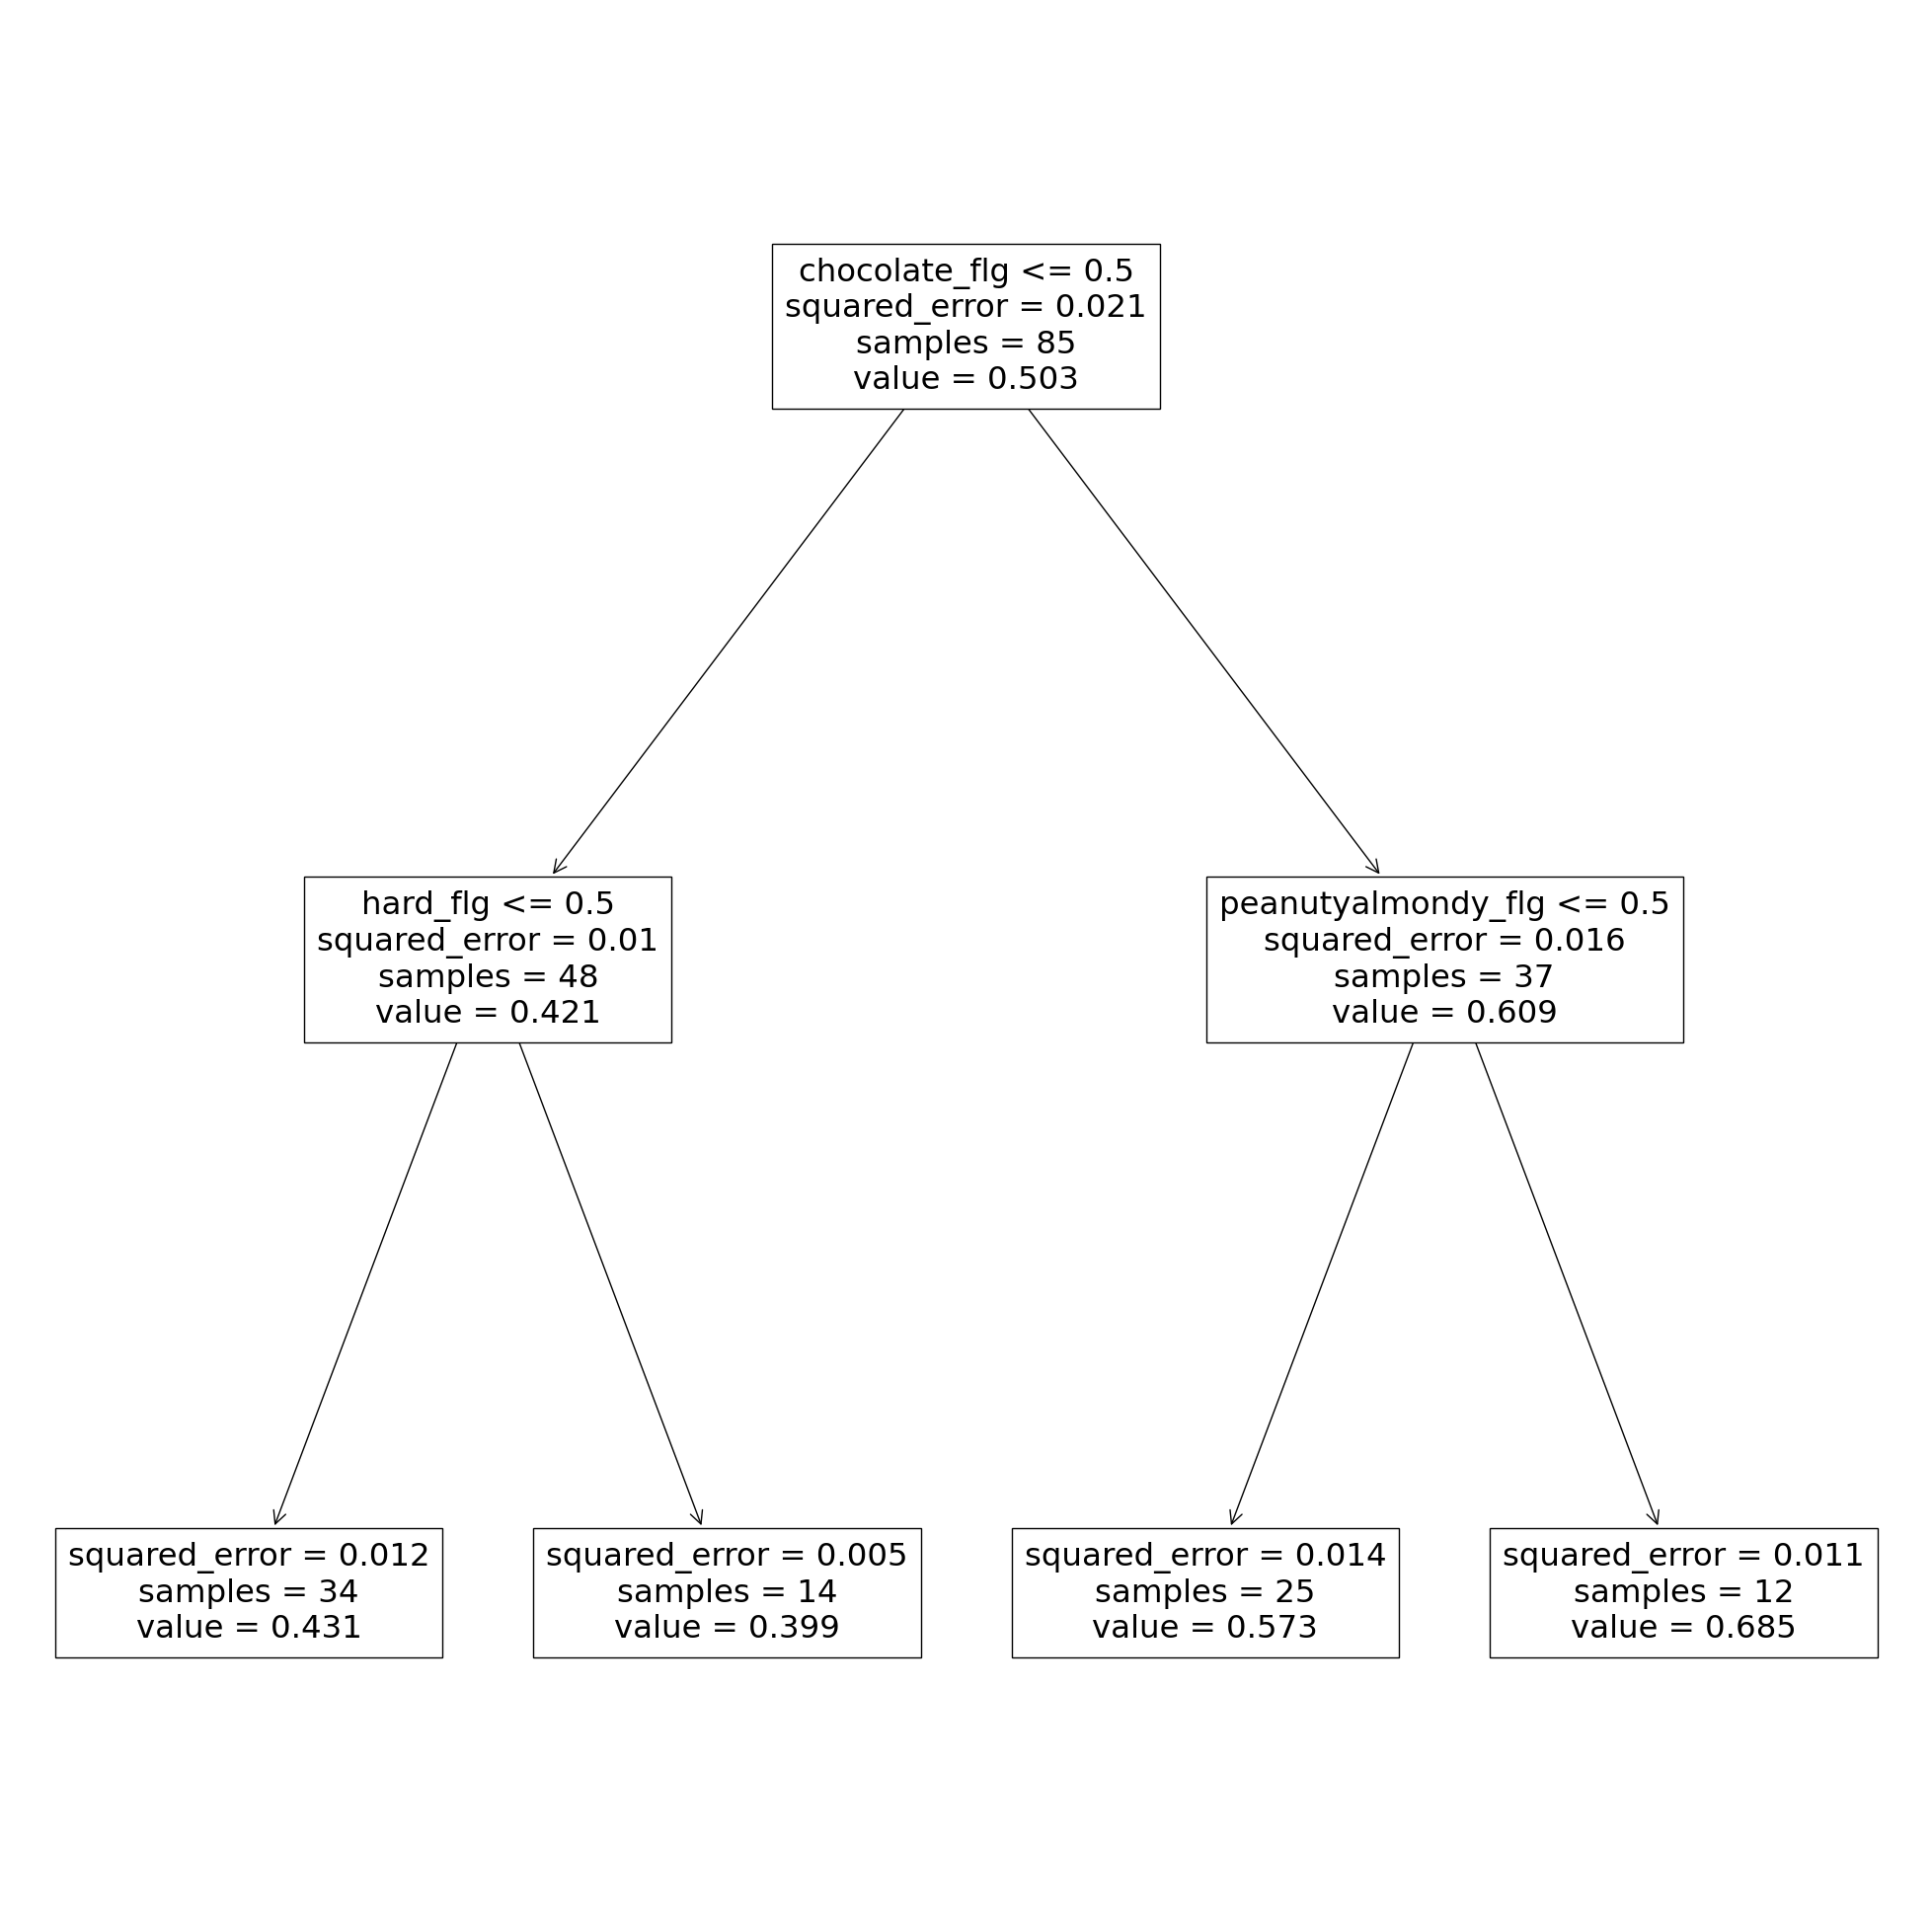

In [40]:
# Finding optimal tree depth. Chosen depth 2.
#finding_optimal_depth(df, x_var, y_var)

model = regression_tree(df, x_var, y_var)
shap_top3_reg_tree = shapley_explainer(model, df.loc[:, x_var], df.loc[top3, x_var])
shap_bot3_reg_tree = shapley_explainer(model, df.loc[:, x_var], df.loc[bot3, x_var])

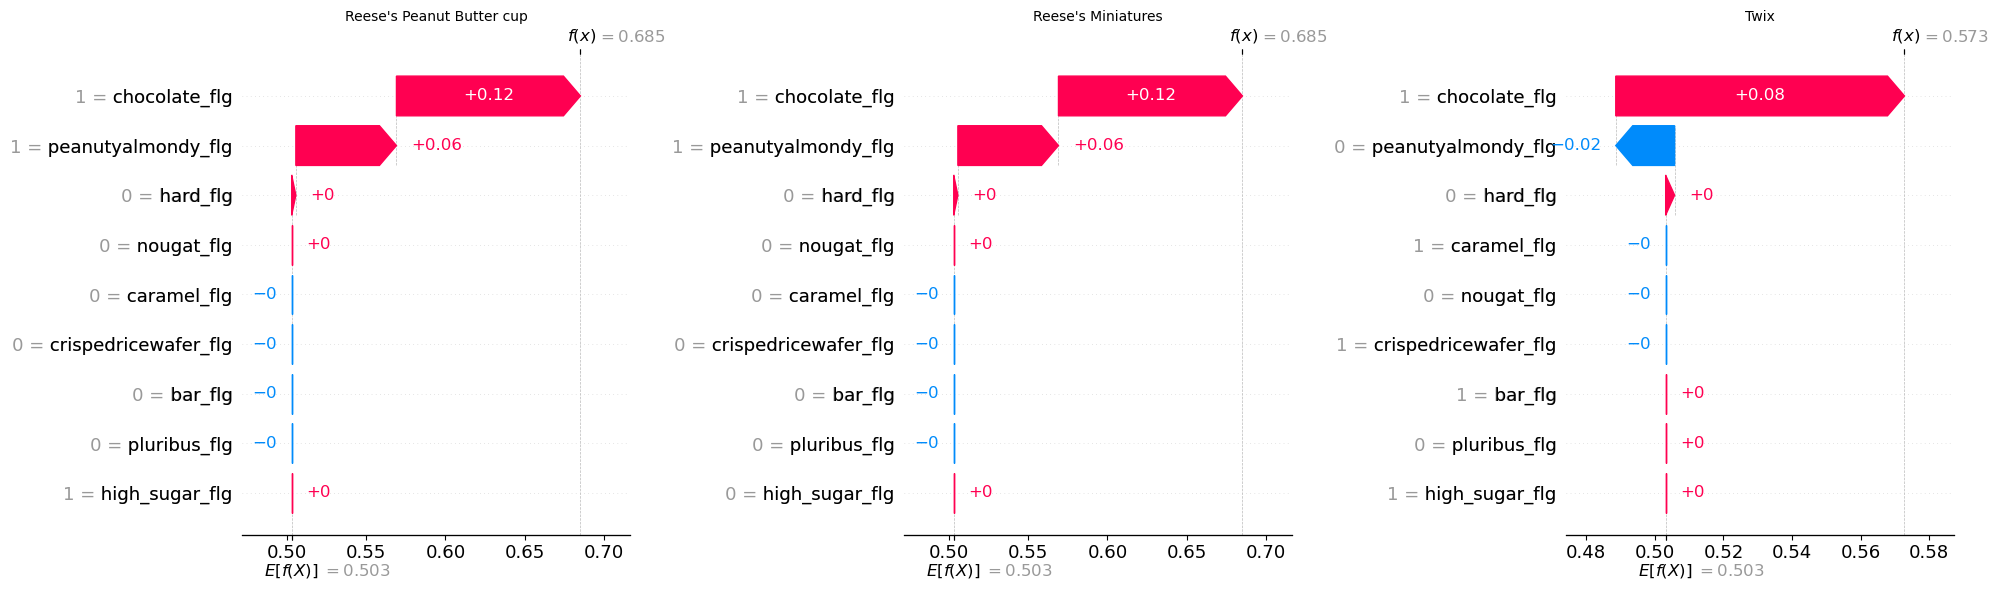

In [34]:
visualize_shapley(shap_top3_reg_tree, top3)

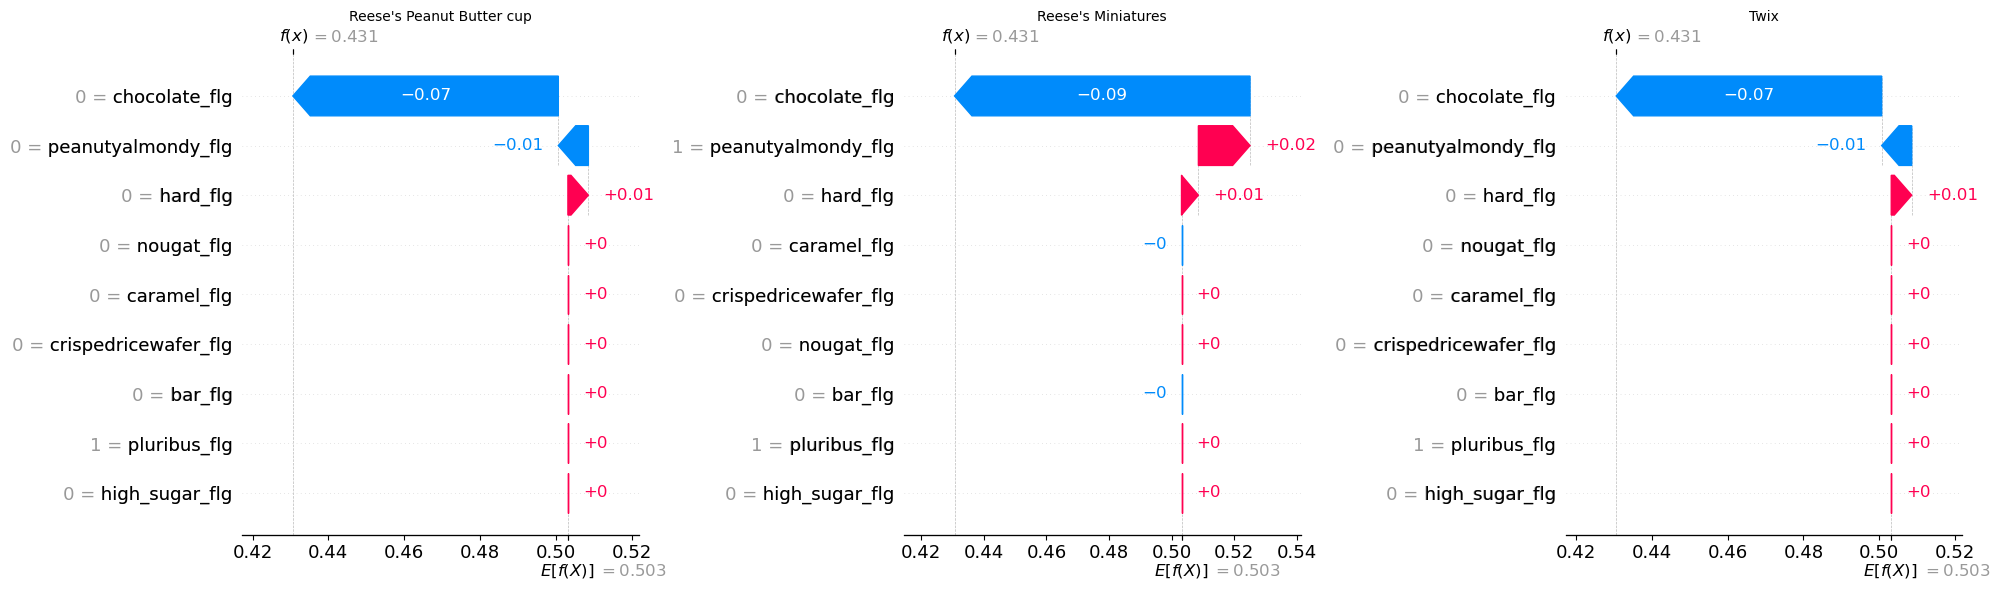

In [36]:
visualize_shapley(shap_bot3_reg_tree, top3)